
# Human-in-the-Loop Interruption in LangGraph

## 1. What is Human-in-the-Loop (HITL)?
- A mechanism where **human oversight** is introduced into an AI workflow.  
- Instead of the AI executing all tool calls automatically, the system **pauses at predefined points** and waits for human confirmation, modification, or rejection.  
- In **LangGraph**, this is done using interruptions (e.g., `interrupt_before=["tools"]`).  

## 2. Why is it Important?
- **Error Prevention**: AI may misinterpret user intent or call the wrong tool (e.g., adding the wrong item to a shopping cart).  
- **Transparency**: Human can see what the AI is about to do before it executes.  
- **Control**: Allows business-critical decisions to stay under human authority.  
- **Compliance**: Useful in regulated industries where AI cannot act without human approval (e.g., finance, healthcare, procurement). 

## Goals

Now, let's talk about the motivations for `human-in-the-loop`:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - We can modify the state 

LangGraph offers several ways to get or update agent state to support various `human-in-the-loop` workflows.
 


We'll show how this enables user `approval`.

## Breakpoints for human approval

Let's assume that are concerned about tool use: we want to approve the agent to use any of its tools.
 
All we need to do is simply compile the graph with `interrupt_before=["tools"]` where `tools` is our tools node.

This means that the execution will be interrupted before the node `tools`, which executes the tool call.

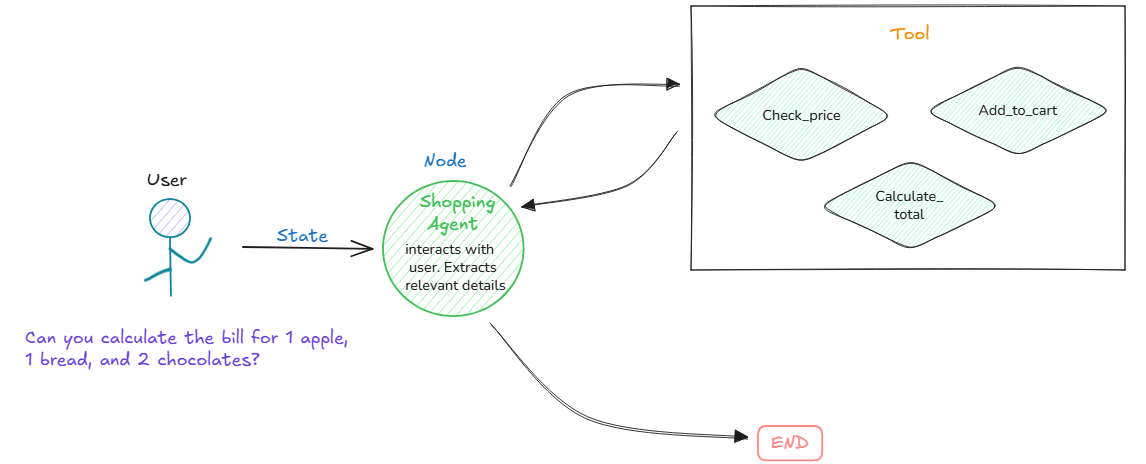

In [6]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [7]:
import os
from langchain_openai import AzureChatOpenAI
from langchain.prompts import ChatPromptTemplate

os.environ["AZURE_OPENAI_API_KEY"] = "your-api-key"
os.environ["AZURE_OPENAI_ENDPOINT"] = "your-endpoint"

llm = AzureChatOpenAI(
    azure_deployment="gpt-4o",   # replace with your deployment name in Azure
    api_version="2024-02-01",    # optional, update if your resource uses a different version
    temperature=0
)

In [8]:

def check_price(item: str) -> float:
    """Check the price of an item in the store (in INR).

    Args:
        item: name of the item (e.g., 'apple', 'milk')

    Returns:
        Price of the item in INR
    """
    prices_inr = {
        "apple": 30.0,      # ₹30 per apple
        "milk": 60.0,       # ₹60 per litre
        "bread": 40.0,      # ₹40 per loaf
        "chocolate": 100.0  # ₹100 per bar
    }
    return prices_inr.get(item.lower(), 0.0)


def add_to_cart(item: str, quantity: int) -> str:
    """Add an item to the cart with given quantity.

    Args:
        item: name of the item
        quantity: number of items to add

    Returns:
        Confirmation message
    """
    return f"Added {quantity} x {item} to your cart."



def calculate_total(prices: list[float]) -> str:
    """Calculate total bill in INR.

    Args:
        prices: list of item prices

    Returns:
        Total price formatted in INR
    """
    total = sum(prices)
    return f"Total bill: ₹{total:.2f}"

# --- Bind tools to LLM ---
tools = [check_price, add_to_cart, calculate_total]

llm_with_tools = llm.bind_tools(tools)

In [11]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message (updated for shopping agent)
sys_msg = SystemMessage(content="You are a helpful shopping agent that helps users check prices, add items to their cart, and calculate the total bill in INR.")

# Node
def agent(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("agent", agent)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    # If the latest message (result) from agent is a tool call -> tools_condition routes to tools
    # If the latest message (result) from agent is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "agent")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
from IPython.display import display, Markdown

# Get the Mermaid code
mermaid_code = graph.get_graph().draw_mermaid()

# Display in Jupyter
display(Markdown(f"```mermaid\n{mermaid_code}\n```"))


```mermaid
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	tools(tools<hr/><small><em>__interrupt = before</em></small>)
	__end__([<p>__end__</p>]):::last
	__start__ --> agent;
	agent -.-> __end__;
	agent -.-> tools;
	tools --> agent;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

```

In [12]:
# Input
initial_input = {"messages": HumanMessage(content="How much does an apple cost?")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

How much does an apple cost?
================================== Ai Message ==================================
Tool Calls:
  check_price (call_5dqM7wxYlcMG39feQLyynMYj)
 Call ID: call_5dqM7wxYlcMG39feQLyynMYj
  Args:
    item: apple


In [13]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  check_price (call_5dqM7wxYlcMG39feQLyynMYj)
 Call ID: call_5dqM7wxYlcMG39feQLyynMYj
  Args:
    item: apple
================================= Tool Message =================================
Name: check_price

30.0
================================== Ai Message ==================================

An apple costs ₹30.


In [19]:
# Input
initial_input = {"messages": HumanMessage(content="Please help adding 10 qty of chocolates")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Please help adding 10 qty of chocolates
================================== Ai Message ==================================
Tool Calls:
  add_to_cart (call_Qc264UtayUffOr91hKRgcrXk)
 Call ID: call_Qc264UtayUffOr91hKRgcrXk
  Args:
    item: chocolates
    quantity: 10


In [20]:
state = graph.get_state(thread)

In [22]:
state.next

('tools',)

In [23]:

# Run the graph until the first interruption
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  add_to_cart (call_Qc264UtayUffOr91hKRgcrXk)
 Call ID: call_Qc264UtayUffOr91hKRgcrXk
  Args:
    item: chocolates
    quantity: 10
================================= Tool Message =================================
Name: add_to_cart

Added 10 x chocolates to your cart.
================================== Ai Message ==================================

I have added 10 chocolates to your cart. Let me know if you need anything else!


In [24]:
# Input
initial_input = {"messages": HumanMessage(content="Add 3 apples and 1 bread loaf to my cart")}

# Thread
thread = {"configurable": {"thread_id": "3"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Add 3 apples and 1 bread loaf to my cart
================================== Ai Message ==================================
Tool Calls:
  add_to_cart (call_awdhRY9ur5eYCD0Efttn10px)
 Call ID: call_awdhRY9ur5eYCD0Efttn10px
  Args:
    item: apple
    quantity: 3
  add_to_cart (call_DfoyWBmOcyREPsB4S5Y4R2HK)
 Call ID: call_DfoyWBmOcyREPsB4S5Y4R2HK
  Args:
    item: bread loaf
    quantity: 1


Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  add_to_cart (call_awdhRY9ur5eYCD0Efttn10px)
 Call ID: call_awdhRY9ur5eYCD0Efttn10px
  Args:
    item: apple
    quantity: 3
  add_to_cart (call_DfoyWBmOcyREPsB4S5Y4R2HK)
 Call ID: call_DfoyWBmOcyREPsB4S5Y4R2HK
  Args:
    item: bread loaf
    quantity: 1
================================= Tool Message =================================
Name: add_to_cart

Added 1 x bread loaf to your cart.
================================== Ai Message ==================================

I have added 3 apples and 1 bread loaf to your cart.


### Breakpoints with LangGraph API

As shown above, we can add `interrupt_before=["node"]` when compiling the graph that is running in Studio.

However, with the API, you can also pass `interrupt_before` to the stream method directly. 

In [25]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [27]:
initial_input = {"messages": HumanMessage(content="Whats the price of 10 apples?")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Whats the price of 10 apples?', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '9d746f44-2bf6-4e1f-8e2e-22f99e38ea89', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_RngHngs1P8PmE0f41r14psEK', 'function': {'arguments': '{"item":"apple"}', 'name': 'check_price'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 15, 'prompt_tokens': 166, 'total_tokens': 181, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 

In [28]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_RngHngs1P8PmE0f41r14psEK', 'function': {'arguments': '{"item":"apple"}', 'name': 'check_price'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 15, 'prompt_tokens': 166, 'total_tokens': 181, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-CKV4Qy5rB0jP5wXubw2bS1oeEuX3G', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 's